# Data Gathering


## The Process

   1. Show an example of an audio signal the features we can extract from it
   2. Describe an FFT and MFCC
   3. Write a method that will create an MFCC for all the given songs in a directory

In [2]:
import os
import math
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
import tensorflow as tf
import pickle

### An Example of Extracting an Audio Signal

To show how a song is composed, we can analyze its changes in air pressure.  A louder song will have a higher air pressure compared to that of a quieter song. Using the Python' Librosa library, we can create a waveform of a song, which will show changes in the air pressure

In [4]:
# Extract the wave, y, and the sample rate, sr, from the file

y, sr = librosa.load('../../../../Classes/OSU/CS467/audio_data/blues.00033.wav')

In [5]:
# Check the shape of y
y.shape

(661794,)

In [7]:
# Check the sampling rate
sr

22050

Text(0, 0.5, 'Amplitude')

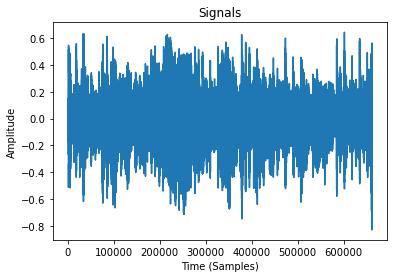

In [9]:
# Plot the wave file
plt.plot(y)
plt.title("Signals")
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude")

### Converting the Signals Into Something More Useful

On an abstract level, a song or audio signal is a composed of various soud waves. If we were to take samples of the signal over a period of time. Using the Fourier transform formula (https://en.wikipedia.org/wiki/Fourier_transform) we can create a spectrum, which will show us the changes of frequency over time. 

This change of frequency over time is known as a fast Fourier tranform

Source: https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

In [12]:
# Calculate the FFT 
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))

Text(0, 0.5, 'Amplitude')

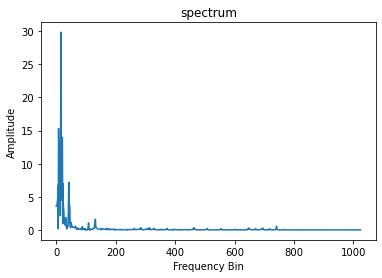

In [13]:
# Plot the FFT:
plt.plot(ft);
plt.title('spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

### Still Getting There To Something Useful

The FFT isn't entirely useful to us.  However, it provides a foundation for further audio processing.  If we can visually represent a signal's loudness over a period of time at different frequencies, we can get a spectrogram.  

In [15]:
# Get the spectrogram
spectrogram = np.abs(librosa.stft(y, hop_length = 512))
spectrogram = librosa.amplitude_to_db(spectrogram, ref = np.max)

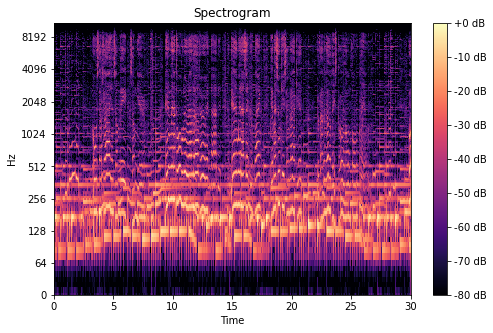

In [18]:
# Plot the spectrogram

plt.figure(figsize = (8,5))
librosa.display.specshow(spectrogram, sr = sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show(block=False)

### MFCC

Mel Frequency Cepstral Coefficients, or MFCC, are often used to identify the components of an audio signal.  They are used in speech recognition, and as well muscial classification.

MFCCs are formed in the following way:

1. Take the Fourier transform of a signal
2. Map the powers of the spectrum from the above signal onto a mel scale
3. Take the logs of the powers at each of the mel frequencies
4. Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
5. The MFCCs are the amplitudes of the resulting spectrum.

Note: We only did steps one and two of the method described above.  Thankfully, the Librosa library has a method that will create an MFCC for us

Source: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

In [19]:
# Extracting mfccs from the audio signal
mfcc = librosa.feature.mfcc(y = y, sr = sr, hop_length = 512, n_mfcc = 13)

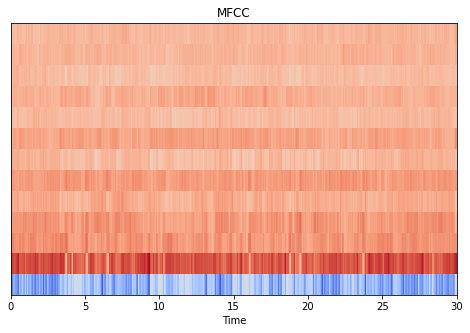

In [20]:
# Plot the MFCC

plt.figure(figsize=(8,5));
librosa.display.specshow(mfcc, x_axis='time');
plt.title('MFCC');

### Function to read and extract data from audio files

In [21]:
# Save the MFCC and export them as numpy arrays

"""Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param track_duration (int): Length of the song, in secods
        :param sr (int): sample rate of the somg
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
"""


def save_mfcc(dataset_path,
              track_duration = 30,
              sr = 22050,
              n_mfcc = 13,
              n_fft = 2048,
              hop_length = 512,
              num_segments = 6):

    mfcc_data = []
    labels = []

    # Map labels to genre
    label_dict = {
        'jazz': 0,
        'reggae': 1,
        'rock': 2,
        'blues': 3,
        'hiphop': 4,
        'country': 5,
        'metal': 6,
        'classical': 7,
        'disco': 8,
        'pop': 9
    }

    samples_per_track = sr * track_duration
    num_samples_per_segment = int(samples_per_track / num_segments)
    expected_num_mfcc_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # Iterate through the files
   
    for file in os.scandir(dataset_path):

        # Parse the file names by genre
        label_key = file.name.split('.')[0]

        # Store the integer label based on genre
        label = label_dict[label_key]

        # Process the files
        signal, sr = librosa.load(file, sr=sr)

        # Progress the segments and extract the MFCC
        for s in range(num_segments):
            start_sample = num_samples_per_segment * s
            finish_sample = start_sample + num_samples_per_segment

            # Ensure MFCC has correct vector length, if it does save it
            mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                        sr=sr,
                                        n_fft=n_fft,
                                        n_mfcc=n_mfcc,
                                        hop_length=hop_length)
            mfcc = mfcc.T

            if len(mfcc) == expected_num_mfcc_per_segment:
                mfcc_data.append(mfcc.tolist())
                labels.append(label)

    mfcc_data = np.array(mfcc_data)
    labels = np.array(labels)

    return mfcc_data, labels

### Call save_mfcc and assign the to variables mfcc and labels

In [13]:
mfcc, labels = save_mfcc('../../audio_data/')

### Ensure the shape of mfcc and labels are the same 

In [14]:
print(f'mfcc.shape: {mfcc.shape}')

mfcc.shape: (5992, 216, 13)


In [15]:
print(f'labels.shape: {labels.shape}')

labels.shape: (5992,)


In [17]:
print("Saving the data")
np.savez('../../audio/audio_data_MFCC/audio_output.npz', mfcc=mfcc, labels=labels)

Saving the data
